# Lab 4 -- Validation Splits and DataLoaders in PyTorch

## AMPTH 207: Stochastic Methods for Data Analysis, Inference and Optimization

**Subtopic:** Train/Validation splits on DataLoaders in PyTorch

**Instructor:** Rahul Dave

**Blame:** Any blame for any errors in this document goes to Patrick

In [42]:
from IPython.lib.display import YouTubeVideo

import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler

### Defining our Dataset

We'll start by defining a dataset not too disimilar to MNIST but a lot simpler.  We replace our (28, 28, 1) ndarrays with (2, 2, 1) versions.  We also implement the ability to handle transforms just so our class fits in with the MNIST-like Dataset/DataLoader scaffolding in torch/torchvision.

In [18]:
class MyCustomPixelDataset(Dataset):
    """
    This dataset is a toy dataset that acts like 2x2 version of MNIST
    with the trace as labels.
    """
    def __init__(self, size=1, transform=None):
        super(MyCustomPixelDataset, self).__init__()
        
        # size determines length of dataset
        self.size = size
        
        # generate random 2x2 matrices with values in [0, 255]
        self.matrices = [np.random.randint(256, size=(2, 2)) for i in range(self.size)]
        
        # our dataset will be a list of (ndarray, label) tuples where the label is the trace
        # reshape our matrices into (2x2x1) ndarrays so that transforms.ToTensor()
        # has the appropriate expected shape
        self.matrices = [(np.reshape(np.array([matrix]), (2,2,1)), np.trace(matrix)) for matrix in self.matrices]
        
        # if we're passed a transform then apply it to the first element of our tuple (the input)
        if transform:
            self.matrices = [(transform(element[0]), element[1]) for element in self.matrices]
        
    # length should just be the size although we don't validate size (i.e. should be an int > 0)
    def __len__(self):
        return self.size
    
    # implement __getitem__ as the indexed tuple 
    def __getitem__(self, index):
        #assert 0 <= index <= self.b - self.a
        
        return self.matrices[index]

**If we look at an example small instance of our dataset, we see that it correctly handles the transforms.ToTensor() operation and matches the structure of the MNIST dataset although we have scalar labels as the trace of the original random 2x2 matrix**

In [26]:
mydset = MyCustomPixelDataset(12,transform=transforms.ToTensor())

In [27]:
mydset[:]

[(
  (0 ,.,.) = 
    0.1020  0.5059
    0.8706  0.4314
  [torch.FloatTensor of size 1x2x2], 136), (
  (0 ,.,.) = 
    0.8000  0.4627
    0.3373  0.1529
  [torch.FloatTensor of size 1x2x2], 243), (
  (0 ,.,.) = 
    0.5922  0.5765
    0.4745  0.0471
  [torch.FloatTensor of size 1x2x2], 163), (
  (0 ,.,.) = 
    0.1725  0.2627
    0.9294  0.5765
  [torch.FloatTensor of size 1x2x2], 191), (
  (0 ,.,.) = 
    0.4314  0.8667
    0.1412  0.7922
  [torch.FloatTensor of size 1x2x2], 312), (
  (0 ,.,.) = 
    0.7373  0.4000
    0.3216  0.5725
  [torch.FloatTensor of size 1x2x2], 334), (
  (0 ,.,.) = 
    0.3333  0.2745
    0.4706  0.7882
  [torch.FloatTensor of size 1x2x2], 286), (
  (0 ,.,.) = 
    0.8510  0.0667
    0.3725  0.6000
  [torch.FloatTensor of size 1x2x2], 370), (
  (0 ,.,.) = 
    0.3412  0.0784
    0.9922  0.9490
  [torch.FloatTensor of size 1x2x2], 329), (
  (0 ,.,.) = 
    0.5647  0.9020
    0.7137  0.3490
  [torch.FloatTensor of size 1x2x2], 233), (
  (0 ,.,.) = 
    0.2392  0

### Defining our DataLoader

We'll now define a DataLoader with a batch_size of 4 and shuffle set to be True.  If things go as expected when we loop through our epochs (we only define two here just to show the functionality) and iterate through the DataLoader, we should see our batches of 4 and they shouldn't come out in a defined order.  Our data should come out in different orders (and different batches) in each epoch.

In [28]:
mydset_loader = torch.utils.data.DataLoader(dataset=mydset, 
                                           batch_size=4, 
                                           shuffle=True)

In [29]:
for epoch in range(2):   
    for batch_index, (inputs, labels) in enumerate(mydset_loader):
        print(epoch, batch_index, labels)

0 0 
 136
 243
 370
 312
[torch.LongTensor of size 4]

0 1 
 334
 163
 191
 233
[torch.LongTensor of size 4]

0 2 
 219
 329
 286
 439
[torch.LongTensor of size 4]

1 0 
 136
 329
 191
 233
[torch.LongTensor of size 4]

1 1 
 370
 334
 312
 286
[torch.LongTensor of size 4]

1 2 
 243
 439
 219
 163
[torch.LongTensor of size 4]



Sure enough our label clusters come in different orders and organized in different batchs in each epoch.

### Splitting out a Validation Set from our Dataset

Our problem is that we're given a dataset but not necessary a validation set.  How do we split out a validation set while still being able to use the convenient dataset/dataloader scaffolding that PyTorch provides?

We'll take the following approach:

* Split our dataset into training set and validation set
* Use the indices of the split to create PyTorch Samplers
* Feed that sampler into our DataLoaders to tell them which dataset elements to include in their iteration
* Iterate over the appropriate DataLoaders in the training/validation loops
* Gnome underpants


In [45]:
## define our indices -- our dataset has 9 elements and we want a 8:4 split
num_train = len(mydset)
indices = list(range(num_train))
split = 4

# Random, non-contiguous split
validation_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(validation_idx))

# Contiguous split
# train_idx, validation_idx = indices[split:], indices[:split]

## define our samplers -- we use a SubsetRandomSampler because it will return
## a random subset of the split defined by the given indices without replaf
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

train_loader = torch.utils.data.DataLoader(mydset, 
                batch_size=4, sampler=train_sampler)

validation_loader = torch.utils.data.DataLoader(mydset, 
                batch_size=2, sampler=validation_sampler)

### Testing our Validation Split

OK -- we should have accomplished the first 3 items on our agenda:

* Split our dataset into training set and validation set
* Use the indices of the split to create PyTorch Samplers
* Feed that sampler into our DataLoaders to tell them which dataset elements to include in their iteration

Now we kind of glossed over an unexpected problem.  If you define any kind of sampler, you lose the ability to designate shuffle as True in your DataLoader.  For this reason we defined our sampler as a SubsetRandomSampler which should ensure shuffling by its very nature.  If all goes as expected, we should be able to iterate through our train_loader and validation_loader and get segmented results -- elements in the validation loader are not in the train_loader and vice versa.  Furthermore, we should see random shuffling batches from our train_loader just as if we designated shuffle to True.

let's test our train_loader:

In [46]:
for epoch in range(2):   
    for batch_index, (inputs, labels) in enumerate(train_loader):
        print(epoch, batch_index, labels)

0 0 
 163
 334
 136
 219
[torch.LongTensor of size 4]

0 1 
 243
 329
 370
 312
[torch.LongTensor of size 4]

1 0 
 329
 334
 163
 243
[torch.LongTensor of size 4]

1 1 
 370
 136
 312
 219
[torch.LongTensor of size 4]



and now our validation_loader:

In [47]:
for epoch in range(2):   
    for batch_index, (inputs, labels) in enumerate(validation_loader):
        print(epoch, batch_index, labels)

0 0 
 233
 191
[torch.LongTensor of size 2]

0 1 
 439
 286
[torch.LongTensor of size 2]

1 0 
 191
 233
[torch.LongTensor of size 2]

1 1 
 286
 439
[torch.LongTensor of size 2]



### Testing Conclusions

RESULT!! No overlap! Now because we use SubsetRandomSampler for both our train_sampler and our validation_sampler as a side effect we get random shuffling on our validation split.  It's not ideal, but not the end of the world.  Unfortunately there isn't a SubsetSequentialSampler class.  We could write our own sampler class (they're quite easy to implement) but since the downside of random shuffling in our validation split aren't onerous, we'll just use the SubsetRandomSampler as a base class for both samplers.  We have achieved our final two objectives:

* Iterate over the appropriate DataLoaders in the training/validation loops
* Gnome underpants

### Train/Validation Splits on the MNIST Dataset

With the above infrastructure in place, we can construct some validation boilerplate code for HW4 Questions 2 and 3 to allow us to create validation sets for MNIST.  Fortunately we don't have to do anything special for the test set, the MNIST code in torchvision already at the right size.  As is, out of the 70K imates in MNIST, the torchvision MNIST dataset  gives us a 60K/10K train/test split.  For the HW we want a 60K/10K/10K train/validation/test split.  You should be able to use the below boilerplate.

In [48]:
## Define our MNIST Datasets (Images and Labels) for training and testing
train_dataset = datasets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = datasets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())


## We need to further split our training dataset into training and validation sets.

# Define the indices
indices = list(range(len(train_dataset))) # start with all the indices in training set
split = 10000 # define the split size

# Define your batch_size
batch_size = 64

# Random, non-contiguous split
validation_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(validation_idx))

# Contiguous split
# train_idx, validation_idx = indices[split:], indices[:split]


# define our samplers -- we use a SubsetRandomSampler because it will return
# a random subset of the split defined by the given indices without replacement
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

# Create the train_loader -- use your real batch_size which you
# I hope have defined somewhere above
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                batch_size=batch_size, sampler=train_sampler)

# You can use your above batch_size or just set it to 1 here.  Your validation
# operations shouldn't be computationally intensive or require batching.
validation_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                batch_size=1, sampler=validation_sampler)

# You can use your above batch_size or just set it to 1 here.  Your test set
# operations shouldn't be computationally intensive or require batching.  We 
# also turn off shuffling, although that shouldn't affect your test set operations
# either
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=1,
                                          shuffle=False)

You're done now! :-)

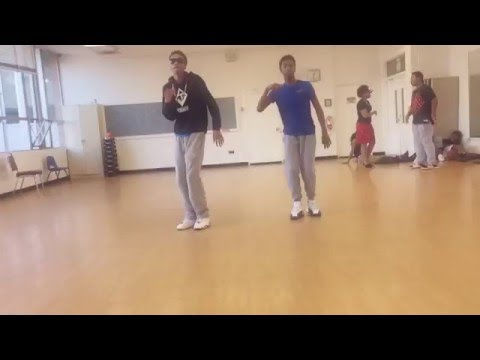

In [43]:
YouTubeVideo('iguPncD11bI')